In [3]:
from PIL import Image 
import os, glob, numpy as np  #os,glob 운영체제 관리  numpy 수학적 표현
from sklearn.model_selection import train_test_split#전체 데이터셋 배열을 받아서 랜덤하게 훈련/테스트 데이터 셋으로 분리해주는 함수

caltech_dir = "./Cat_Class"
categories = ["Persian","Siberia","boom","Rusianblue"]
nb_classes = len(categories)
#이미지 크기 64 X 64
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data) #변경한 img 데이터 파일을 X리스트에 추가
        y.append(label) 

        if i % 700 == 0: 
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)



X_train, X_test, y_train, y_test = train_test_split(X, y) #tarain_test x값과 y값을 각 저장
xy = (X_train, X_test, y_train, y_test) 
np.save("./numpy_data/multi_image_data.npy", xy) #npy파일로 저장 

print("ok", len(y))


Persian  파일 길이 :  826
Persian  :  ./Cat_Class/Persian\persian (1).jpg
Persian  :  ./Cat_Class/Persian\persian256.jpg
Siberia  파일 길이 :  1672
Siberia  :  ./Cat_Class/Siberia\Siberia (1).jpg
Siberia  :  ./Cat_Class/Siberia\Siberia (211).jpg
Siberia  :  ./Cat_Class/Siberia\Siberia (842).jpg
boom  파일 길이 :  599
boom  :  ./Cat_Class/boom\001.jpg
Rusianblue  파일 길이 :  2262
Rusianblue  :  ./Cat_Class/Rusianblue\Rusianblue(1).jpg
Rusianblue  :  ./Cat_Class/Rusianblue\Rusianblue(1629).jpg
Rusianblue  :  ./Cat_Class/Rusianblue\Rusianblue(2259).jpg
Rusianblue  :  ./Cat_Class/Rusianblue\Rusianblue(853).jpg
ok 5359


이제 numpy 데이터를 불러온다. 저것을 가지고 학습!

In [5]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K #GPU 구현을 위한 함수 

import tensorflow as tf     #GPU 환경구현에 있어서 메모리를 절약해서 사용하기 위한 코드 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data.npy')
print(X_train.shape)
print(X_train.shape[0])

(4019, 64, 64, 3)
4019


In [6]:
categories = ["Persian","Siberia","boom","Rusianblue"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [9]:
with K.tf_ops.device('/device:GPU:0'): #CNN , GPU 환경 구현화 선형 -> 비선형 ->플링 계층
    model = Sequential() #선형계층을 형성
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))# CNN기본환경 Conv2D사용 relu(비선형계층) 로 활성화
    model.add(MaxPooling2D(pool_size=(2,2)))#플링 계층
    model.add(Dropout(0.2))# 에러율 감소를 위해 사용하는 훈련함수
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten()) #다차원배열을 1차원 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_classes, activation='softmax'))#softmax함수의 출력은 0부터 1사이의 실수이며 ,출력의 총합은 1을 표현해주고,확률할때 사용해준다
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #metrics 분석측정 즉 정확도
    model_dir = './model'                       #optimizer 딥러닝에서 학습속도를 빠르고 안정하게 
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    #ModelCheckpoint keras에서 모델을 학슬할 때마다 중간중간 콜백 형태로 알려줌 , verborse 함수의 진행 사항의 출력 여부, 
    #save_besr_only 모델의 정확도가 최고값을 갱신했을 때만 저장하도록 하는 옵션
    early_stopping = EarlyStopping(monitor='val_loss', patience=6) #학습종료 patience 성능이 증가하지 않는 epoch를 몇번이나 몇번이가 허용할 것인가 
    
    

In [10]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)      

In [11]:
 history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test),
                     callbacks=[checkpoint, early_stopping])
    #early_stopping 학습종료


Train on 4019 samples, validate on 1340 samples
Epoch 1/50
4019/4019 [==============================] - 38s 9ms/step - loss: 1.0701 - accuracy: 0.5061 - val_loss: 0.7715 - val_accuracy: 0.6709

Epoch 00001: val_loss improved from inf to 0.77147, saving model to ./model/multi_img_classification.model
Epoch 2/50
4019/4019 [==============================] - 42s 10ms/step - loss: 0.7383 - accuracy: 0.6706 - val_loss: 0.6527 - val_accuracy: 0.7425

Epoch 00002: val_loss improved from 0.77147 to 0.65271, saving model to ./model/multi_img_classification.model
Epoch 3/50
4019/4019 [==============================] - 44s 11ms/step - loss: 0.6145 - accuracy: 0.7435 - val_loss: 0.5424 - val_accuracy: 0.8090

Epoch 00003: val_loss improved from 0.65271 to 0.54241, saving model to ./model/multi_img_classification.model
Epoch 4/50
4019/4019 [==============================] - 43s 11ms/step - loss: 0.5213 - accuracy: 0.7982 - val_loss: 0.4383 - val_accuracy: 0.8470

Epoch 00004: val_loss improved from

In [12]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

1340/1340 [==============================] - 3s 2ms/step
정확도 : 0.9306


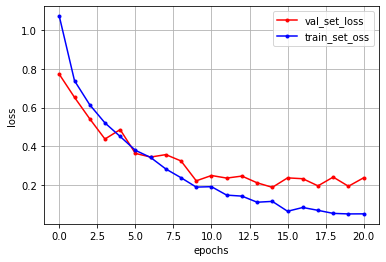

In [13]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss') #데이터셋
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss') #훈련데이터
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [15]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "./Cat_Class/imgs_others"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0


for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "Persian"
    elif pre_ans == 1: pre_ans_str = "Siberia"
    elif pre_ans == 2: pre_ans_str = "boom"    
    elif pre_ans == 3 : pre_ans_str = "Rusianblue"  
    if i[0] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.


[0.000 0.000 1.000 0.000]
2
해당 028.jpg이미지는 boom으로 추정됩니다.
[0.000 0.000 1.000 0.000]
2
해당 cat.174.jpg이미지는 boom으로 추정됩니다.
[0.000 0.000 1.000 0.000]
2
해당 cat.190.jpg이미지는 boom으로 추정됩니다.
[0.000 1.000 0.000 0.000]
1
해당 persian (1).jpg이미지는 Siberia으로 추정됩니다.
[0.000 0.000 0.000 1.000]
3
해당 Rusianblue(39).jpg이미지는 Rusianblue으로 추정됩니다.
[0.000 1.000 0.000 0.000]
1
해당 Siberia (1).jpg이미지는 Siberia으로 추정됩니다.


비록 데이터가 적지만 그래도 나름 학습이 잘 되었습니다.

하지만 **validation data와 test data가 나뉘어져 있지 않습니다.**

이는 매우 위험한 시도입니다. 왜냐하면 검증 단계에서 테스트 데이터를 사용했는데 또 마지막에 정확도 검출 시 test_data를 사용합니다.

데이터가 충분하다면 이런짓은 하지 않는게 좋습니다!

하지만 새로운 데이터에 대한 예측은 그래도 잘 하는군요!